## **Summary**
    0. Imports
    1. Load Data
    2. Creating Training set
    3. Training Model
    4. Predict Accident Dates in Texts
    5. Predict Dates in Test Data 

# 0. import

In [1]:
import os
import re
import pandas as pd
from utils import *
import pickle
import nltk
from tqdm import tqdm
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
nltk.download('wordnet')
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from xgboost import XGBClassifier

[nltk_data] Downloading package wordnet to /home/fei/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/fei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 1. Load data

In [2]:
# author code
x_tr_df = pd.read_csv('train_folder/x_train_ids.csv', index_col=0)
tr_dir = "train_folder/txt_files/"
tr_files = x_tr_df['filename'].values

# tr_texts has all the texts in it
tr_texts = []
for tr_file in tr_files:
    f = open(os.path.join(tr_dir, tr_file), "r")
    f = f.read()
    f = clean1(f)
    tr_texts.append(f) 
    
#text labels
y_tr_df = pd.read_csv('train_folder/Y_train_predilex.csv', index_col=0)

In [53]:
y_tr_df.head()

,sexe,date_accident,date_consolidation
ID,,,
0,homme,1991-04-09,n.c.
1,homme,2005-06-10,2010-01-19
2,femme,1997-09-26,n.c.
3,femme,1982-08-07,1982-11-07
4,homme,1996-11-26,n.c.


In [54]:
# Custom Patterns
pattern1 = r"\d{1,2} \w{3,9} \d{2,4}"
pattern2 = r"1° \w{3,9} \d{2,4}"
pattern3 = r"1er \w{3,9} \d{2,4}"
pattern4 = r"\d{1,2}/\d{1,2}/\d{2,4}"
pattern5 = r"\d{1,2} / \d{1,2} / \d{2,4}"
pattern6 = r"\d{1,2}/ \d{1,2}/ \d{2,4}"


pattern1_bis = r"(\d{1,2}) (\w{3,9}) (\d{2,4})"
pattern2_bis = r"(1°) (\w{3,9}) (\d{2,4})"
pattern3_bis = r"(1er) (\w{3,9}) (\d{2,4})"
pattern4_bis = r"(\d{1,2})/(\d{1,2})/(\d{2,4})"
pattern5_bis = r"(\d{1,2}) / (\d{1,2}) / (\d{2,4})"
pattern6_bis = r"(\d{1,2})/ (\d{1,2})/ (\d{2,4})"

patterns = [pattern1, pattern2, pattern3, pattern4, pattern5, pattern6] 
patterns_bis = [pattern1_bis, pattern2_bis, pattern3_bis, pattern4_bis, pattern5_bis, pattern6_bis] 

# 2. Creating Training Set

#### Creating a dataset for accident and no accident classification

In [56]:
stemmer = SnowballStemmer('french')
lemmatizer = WordNetLemmatizer()
stop_words = list(stopwords.words('french'))

In [57]:
months_str_to_int = dict(janvier='01', fevrier='02', mars='03', avril='04', mai='05', juin='06',
                         juillet='07', aout='08', septembre='09', octobre='10', novembre='11',
                         decembre='12')

In [58]:
leftover = [] # useful for a deep learning approach when we have to train a language model based on the french jurisprudence texts
x_train = []
y_train = []

for i in tqdm(range(len(tr_texts))):
    text = tr_texts[i]
    if y_tr_df.iloc[i]['date_consolidation'] != 'n.c.' and y_tr_df.iloc[i]['date_consolidation'] != 'n.a.':
        index = []
        dates = []
        for k, pattern in enumerate(patterns):
            index.extend(re.finditer(pattern, text))
            dates.extend(re.findall(patterns_bis[k], text))

        zipped = sorted(list(zip(index,dates)), key = lambda x: x[0].start())
        for j in range((len(index))):
            index[j] = zipped[j][0]
            dates[j] = zipped[j][1]
        start_index = index[2].end()
        index = index[3:]
        dates = dates[3:]

        window = 100
        sequences = []
        for k, ind in enumerate(index):
            day, month, year = dates[k][0], dates[k][1], dates[k][2]
            month = month.lower().replace('é', 'e').replace('û', 'u')
            if (month in months_str_to_int) or (month in months_str_to_int.values()):
                day, month, year = format_date(day, month, year)
                date = f"{year}-{month}-{day}"

                if date == y_tr_df.iloc[i]['date_consolidation']: y_train.append(1)
                else: y_train.append(0)

                match1 = re.match(r"[^\.]*(\.)", text[ind.end(): ind.end() + window])        
                match2 = re.match(r"[^\.]*(\.)", text[ind.start() - window : ind.start()][::-1])

                if match2: start = len(text[:ind.start()]) - match2.end() + 1
                else: start = ind.start() - window
                if match1: end = len(text[:ind.end()]) + match1.end()
                else: end = ind.end() + window

                chunk = text[start:end]
                if start == ind.start() - window: chunk = re.sub(r"^[^\s]*\s*", "", chunk)
                if end == ind.end() + window: chunk = re.sub(r"\s*[^\s]*$", "", chunk)

                chunk = clean2(chunk, lemmatizer, stemmer, stop_words = stop_words)
                x_train.append(chunk)
                
                #if (start, end) in sequences and y_train[-1] == 1: print('text ' + str(i), (start,end))
                sequences.append((start,end))
                

        final = []
        i = 0
        while i != len(sequences):
            start = sequences[i][0]
            while i+1 != len(sequences) and sequences[i+1][0] == start:
                i += 1
            end = sequences[i][1]
            i += 1
            final.append((start,end))

        sequences = [(start_index, final[0][0])]
        for i in range(len(final)-1):
            sequences.append((final[i][1], final[i+1][0]))
        sequences.append((final[-1][1],-1))

        lf = ''
        for s in sequences:
            if s[1] == -1 or s[1] - s[0] >= 20: 
                morceau = re.sub(r"^[^\s]*\s*", "", text[s[0]:s[1]])
                if s[1] != -1: morceau = re.sub(r"\s*[^\s]*$", "", morceau)
                lf = lf + morceau + '. '
        lf = lf[:-1]
        leftover.append(lf)

    else:
        index = []
        for k, pattern in enumerate(patterns):
            index.extend(re.finditer(pattern, text))

        index = sorted(index, key = lambda x: x.start())
        start_index = index[2].end()
        leftover.append(text[start_index:].strip())

100%|██████████| 770/770 [00:19<00:00, 38.70it/s]


In [13]:
pickle.dump(leftover, open('leftover.pkl', 'wb'))

In [59]:
y_train = np.array(y_train)

# 3. Training Model

In [61]:
TF_IDF = TfidfVectorizer(ngram_range=(1, 2), max_features=1000, norm='l2', sublinear_tf=True)
x_train = TF_IDF.fit_transform(x_train).toarray()

In [165]:
random_state = 42

param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [.1],
    'subsample': [.7, .9],
    'colsample_bytree': [.7, .9],
}
classifier, best_thresh, best_params = grid_search(x_train, y_train, param_grid)

KeyboardInterrupt: 

In [62]:
classifier = XGBClassifier(max_depth = 5,
                           learning_rate = 0.1,
                           subsample = 0.7,
                           colsample_bytree = 0.9,
                           random_state = 42)

In [63]:
classifier.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.7, tree_method=None,
              validate_parameters=False, verbosity=None)

In [64]:
proba = classifier.predict_proba(x_train)

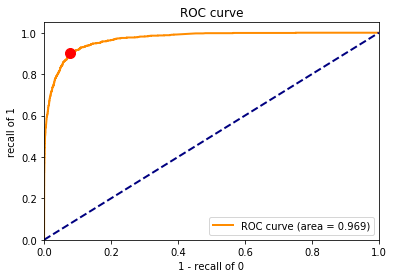

optimal threshold is 0.06829638034105301


In [65]:
t, _ = find_opti_thresh(y_train, proba[:,1])

# 4. Predict Accident Dates in Texts

In [66]:
candidates = []
candidates_txt = []
sentence_dates = []
true_dates = []
for i in tqdm(range(len(tr_texts))):
    if y_tr_df.iloc[i]['date_consolidation'] != 'n.c.' and y_tr_df.iloc[i]['date_consolidation'] != 'n.a.':
        text = tr_texts[i]
        index = []
        dates = []
        for k, pattern in enumerate(patterns):
            index.extend(re.finditer(pattern, text))
            dates.extend(re.findall(patterns_bis[k], text))
            
        zipped = sorted(list(zip(index,dates)), key = lambda x: x[0].start())
        for j in range((len(index))):
            index[j] = zipped[j][0]
            dates[j] = zipped[j][1]
        index = index[3:]
        dates = dates[3:]
        
        window = 100
        data = []
        data_txt = []
        s_d = []
        for k, ind in enumerate(index):
            day, month, year = dates[k][0], dates[k][1], dates[k][2]
            month = month.lower().replace('é', 'e').replace('û', 'u')
            if month in months_str_to_int or month in months_str_to_int.values():
                day, month, year = format_date(day, month, year)
                date = f"{year}-{month}-{day}"
                s_d.append(date)
                
                match1 = re.match(r"[^\.]*(\.)", text[ind.end(): ind.end() + window])        
                match2 = re.match(r"[^\.]*(\.)", text[ind.start() - window : ind.start()][::-1])
                if match2: start = len(text[:ind.start()]) - match2.end() + 1
                else: start = ind.start() - window
                if match1: end = len(text[:ind.end()]) + match1.end()
                else: end = ind.end() + window

                chunk = text[start:end]
                if start == ind.start() - window: chunk = re.sub(r"^[^\s]*\s*", "", chunk)
                if end == ind.end() + window: chunk = re.sub(r"\s*[^\s]*$", "", chunk)
                    
                data_txt.append(chunk)

                chunk = clean2(chunk, lemmatizer, stemmer, stop_words = stop_words)
                data.append(chunk)

        candidates.append(data)
        candidates_txt.append(data_txt)
        sentence_dates.append(s_d)
        true_dates.append(y_tr_df.iloc[i]['date_consolidation'])

100%|██████████| 770/770 [00:15<00:00, 49.72it/s]


In [67]:
for i in range(len(candidates)):
    candidate = TF_IDF.transform(candidates[i]).toarray()
    candidates[i] = candidate

In [68]:
preds = []
all_scores = []
for i, candidate in enumerate(candidates):
    out = classifier.predict_proba(candidate)[:,1]
    all_scores.append(list(out))
    pred = np.argmax(out)
    score = np.max(out)
    
    pred_date = sentence_dates[i][pred]
    preds.append(pred_date)

In [69]:
accuracy = 0
for i in range(len(preds)):
    if preds[i] == true_dates[i]:
        accuracy += 1
accuracy/len(preds)

0.8797327394209354

#  5. Predict Dates in Test Data 

In [70]:
#x_test data
x_te_df = pd.read_csv('test_folder/x_test_ids.csv', index_col=0)
te_dir = "test_folder/txt_files/"
te_files = x_te_df['filename'].values
te_texts = []
for te_file in te_files:
    f = open(os.path.join(te_dir, te_file), "r")
    f = f.read()
    f = clean1(f)
    te_texts.append(f)

In [71]:
candidates = []
sentence_dates = []
for i in tqdm(range(len(te_texts))):
    text = te_texts[i]
    index = []
    dates = []
    for k, pattern in enumerate(patterns):
        index.extend(re.finditer(pattern, text))
        dates.extend(re.findall(patterns_bis[k], text))

    zipped = sorted(list(zip(index,dates)), key = lambda x: x[0].start())
    for j in range((len(index))):
        index[j] = zipped[j][0]
        dates[j] = zipped[j][1]
    index = index[3:]
    dates = dates[3:]
    
    window = 100
    data = []
    s_d = []
    for k, ind in enumerate(index):
        day, month, year = dates[k][0], dates[k][1], dates[k][2]
        month = month.lower().replace('é', 'e').replace('û', 'u')
        if month in months_str_to_int:
            day, month, year = format_date(day, month, year)
            date = f"{year}-{month}-{day}"
            s_d.append(date)

            match1 = re.match(r"[^\.]*(\.)", text[ind.end(): ind.end() + window])        
            match2 = re.match(r"[^\.]*(\.)", text[ind.start() - window : ind.start()][::-1])
            if match2: start = len(text[:ind.start()]) - match2.end() + 1
            else: start = ind.start() - window
            if match1: end = len(text[:ind.end()]) + match1.end()
            else: end = ind.end() + window

            chunk = text[start:end]
            if start == ind.start() - window: chunk = re.sub(r"^[^\s]*\s*", "", chunk)
            if end == ind.end() + window: chunk = re.sub(r"\s*[^\s]*$", "", chunk)

            chunk = clean2(chunk, lemmatizer, stemmer, stop_words = stop_words)
            data.append(chunk)

    candidates.append(data)
    sentence_dates.append(s_d)

100%|██████████| 257/257 [00:07<00:00, 32.80it/s]


In [72]:
for i in range(len(candidates)):
    candidate = TF_IDF.transform(candidates[i]).toarray()
    candidates[i] = candidate

In [73]:
preds = []
for i, candidate in enumerate(candidates):
    pred = np.argmax(classifier.predict_proba(candidate)[:,1])
    score = np.max(classifier.predict_proba(candidate)[:,1])
    if score < t: preds.append('n.c.')
    else:
        pred_date = sentence_dates[i][pred]
        preds.append(pred_date)

In [74]:
np.save('results/consolidation.npy', preds)